# Mathematical Underpinnings - Lab 4

In [1]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, pearsonr
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
import pandas as pd
from tqdm import tqdm

In [2]:
np.random.seed = 42

## Task 1

### a)

#### bp 1)

In [3]:
# a heatmap
# you may use pcolormesh function and draw a heatmap for a sample
# or draw a heatmap for a teoretic density function

# I give you an answer to that task, because it may take too much time to do it during labs. 

In [4]:
def plot_xyz(data_2d, nbins=300):
    x = data_2d[:,0]
    y = data_2d[:,1]
    k = gaussian_kde([x, y])
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    return xi, yi, zi

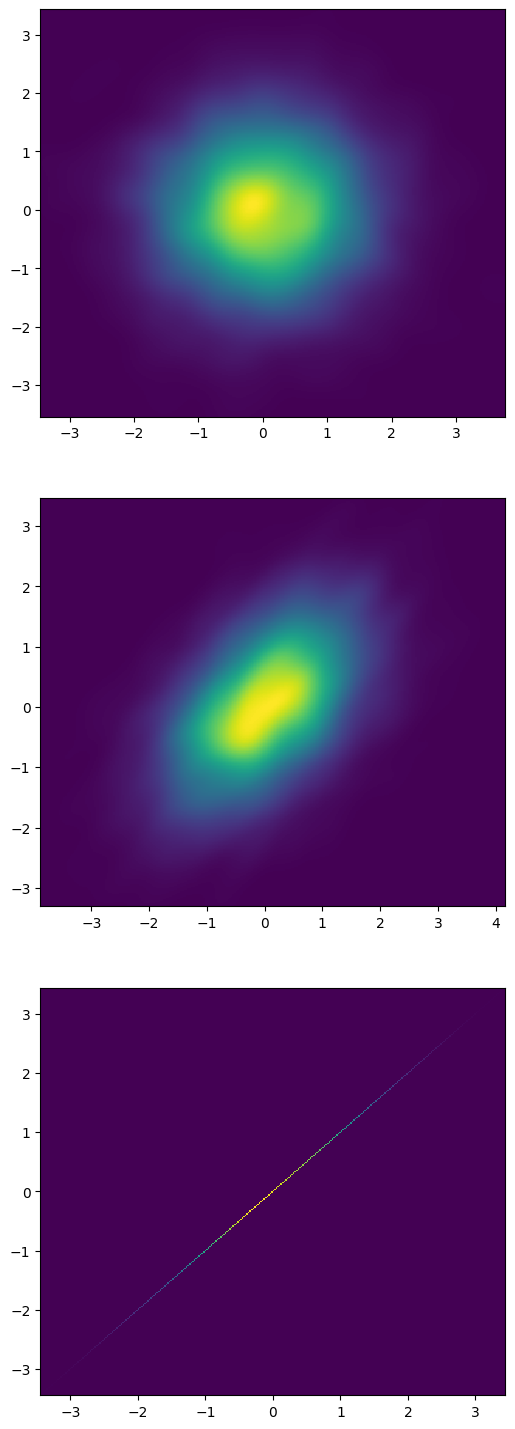

In [5]:
fig, axs = plt.subplots(3, figsize=(6, 18))

n = 5000

data_2d = np.random.multivariate_normal(np.zeros(2), np.array([[1, 0], [0, 1]]), n)
xi_0, yi_0, zi_0 = plot_xyz(data_2d)
data_2d = np.random.multivariate_normal(np.zeros(2), np.array([[1, 0.5], [0.5, 1]]), n)
xi_1, yi_1, zi_1 = plot_xyz(data_2d)
data_2d = np.random.multivariate_normal(np.zeros(2), np.array([[1, 1], [1, 1]]), n)
xi_2, yi_2, zi_2 = plot_xyz(data_2d)
 
# Make the plot
axs[0].pcolormesh(xi_0, yi_0, zi_0.reshape(xi_0.shape), shading='auto')
axs[1].pcolormesh(xi_1, yi_1, zi_1.reshape(xi_1.shape), shading='auto')
axs[2].pcolormesh(xi_2, yi_2, zi_2.reshape(xi_2.shape), shading='auto')
plt.show()

#### bp 2)

In [6]:
def generate_data(rho, n):
    return np.random.multivariate_normal(np.zeros(2), np.array([[1, rho], [rho, 1]]), n)

def discretize(vector, bins=10):
    return np.digitize(vector, np.linspace(vector.min(), vector.max(), bins))

def custom_mutual_info_discrete(x, y, bins=10): 
    contingency = np.histogram2d(x, y, bins=bins)[0]
    contingency = contingency / np.sum(contingency)
    current_sum = 0
    for i in range(contingency.shape[0]):
        for j in range(contingency.shape[1]):
            if contingency[i, j] != 0:
                current_sum += contingency[i, j] * np.log(contingency[i, j] / (np.sum(contingency[i, :]) * np.sum(contingency[:, j])))
    return current_sum

def sklearn_mutual_info_discrete(x, y):
    return mutual_info_classif(x.reshape(-1, 1), y, discrete_features=True)[0]

def calculate_stats(data):
    pearson_rho = pearsonr(data[:, 0], data[:, 1]).statistic
    x = discretize(data[:, 0])
    y = discretize(data[:, 1])
    custom_mi = custom_mutual_info_discrete(x, y)
    sklearn_mi = sklearn_mutual_info_discrete(x, y)
    return pearson_rho, custom_mi, sklearn_mi

def perform_experiment(rho, n):
    data = generate_data(rho, n)
    return calculate_stats(data)

In [7]:
perform_experiment(rho=0, n=1000)

(0.04082565092746382, 0.035319967447337404, 0.035319967447337265)

In [8]:
perform_experiment(rho=0.5, n=1000)

(0.546867192844775, 0.19305342558625202, 0.19305342558625174)

In [9]:
perform_experiment(rho=1, n=1000)

(0.9999999999999987, 1.783112436367687, 1.7831124363676862)

#### bp 3)

In [10]:
rhos = np.linspace(-1, 1, 17)
rhos

array([-1.   , -0.875, -0.75 , -0.625, -0.5  , -0.375, -0.25 , -0.125,
        0.   ,  0.125,  0.25 ,  0.375,  0.5  ,  0.625,  0.75 ,  0.875,
        1.   ])

In [11]:
N = 100

In [12]:
pearson_rhos = np.zeros((len(rhos), N))
custom_mis = np.zeros((len(rhos), N))
sklearn_mis = np.zeros((len(rhos), N))
for i, rho in tqdm(enumerate(rhos)):
    for j in range(N):
        pearson_rhos[i, j], custom_mis[i, j], sklearn_mis[i, j] = perform_experiment(rho, 1000)

2it [00:00,  7.14it/s]

17it [00:02,  6.90it/s]


In [13]:
pearson_rhos_df = pd.DataFrame(pearson_rhos, index = rhos)
mis_df = pd.DataFrame(custom_mis, index=rhos)

In [14]:
pearson_rhos_df = pearson_rhos_df.stack().reset_index()
pearson_rhos_df.columns = ['rho', 'id', 'value']
pearson_rhos_df["measure"] = "Pearson corr. coef."

mis_df = mis_df.stack().reset_index()
mis_df.columns = ['rho', 'id', 'value']
mis_df["measure"] = "Mutual Information"

In [15]:
res_df = pd.concat([pearson_rhos_df, mis_df])

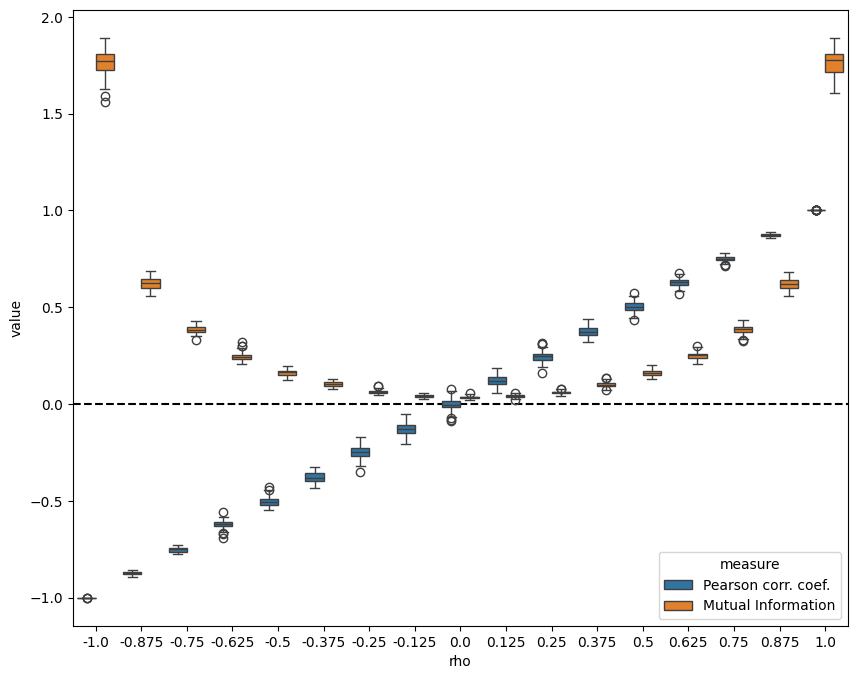

In [16]:
plt.figure(figsize=(10, 8))
plt.axhline(0, color="black", linestyle="--")
sns.boxplot(data=res_df, x='rho', y='value', hue='measure')
plt.show()

<Axes: xlabel='rho', ylabel='value'>

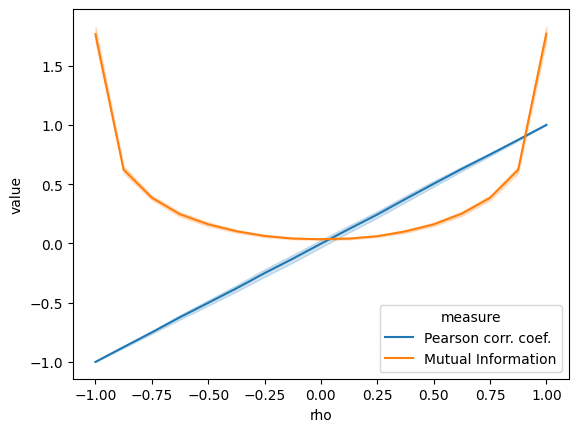

In [17]:
sns.lineplot(data=res_df, x='rho', y='value', hue='measure', errorbar='sd')

#### bp 4)

A hint: note that mutual information between two correlated normal distributions i.e. when $(X, Y)\sim \mathcal{N}((0,0)', \Sigma)$ and
$$\Sigma = \begin{pmatrix}
        \sigma_x^2 & \rho \\ \rho & \sigma_y^2
    \end{pmatrix}$$
equals
$$I(X,Y) = \frac{1}{2}\log \left(\frac{\sigma_x^2\sigma_y^2}{\sigma_x^2\sigma_y^2 - \rho^2}\right).$$

In [18]:
log_df = pearson_rhos_df.copy()
log_df = log_df.loc[np.abs(log_df["rho"]) < 1]
log_df["calculated_mi_rho_theoretical"] = -np.log(1 - log_df["rho"] ** 2) / 2
log_df["calculated_mi_rho_estimated"] = -np.log(1 - log_df["value"] ** 2) / 2
log_df = log_df.drop("measure", axis=1)
log_df = log_df.rename(columns={"value": "rho_estimated"})
log_df = log_df.join(mis_df.set_index(["rho", "id"]), on=["rho", "id"])
log_df = log_df.rename(columns={"value": "estimated_mi"}).drop("measure", axis=1)
log_df

,rho,id,rho_estimated,calculated_mi_rho_theoretical,calculated_mi_rho_estimated,estimated_mi
100,-0.875,0,-0.887608,0.725416,0.775224,0.649301
101,-0.875,1,-0.868469,0.725416,0.701695,0.609102
102,-0.875,2,-0.875779,0.725416,0.728335,0.618259
103,-0.875,3,-0.866845,0.725416,0.695996,0.584676
104,-0.875,4,-0.863425,0.725416,0.684234,0.612698
...,...,...,...,...,...,...
1595,0.875,95,0.862783,0.725416,0.682061,0.598331
1596,0.875,96,0.868004,0.725416,0.700058,0.563185
1597,0.875,97,0.877395,0.725416,0.734450,0.615817
1598,0.875,98,0.876262,0.725416,0.730155,0.631343


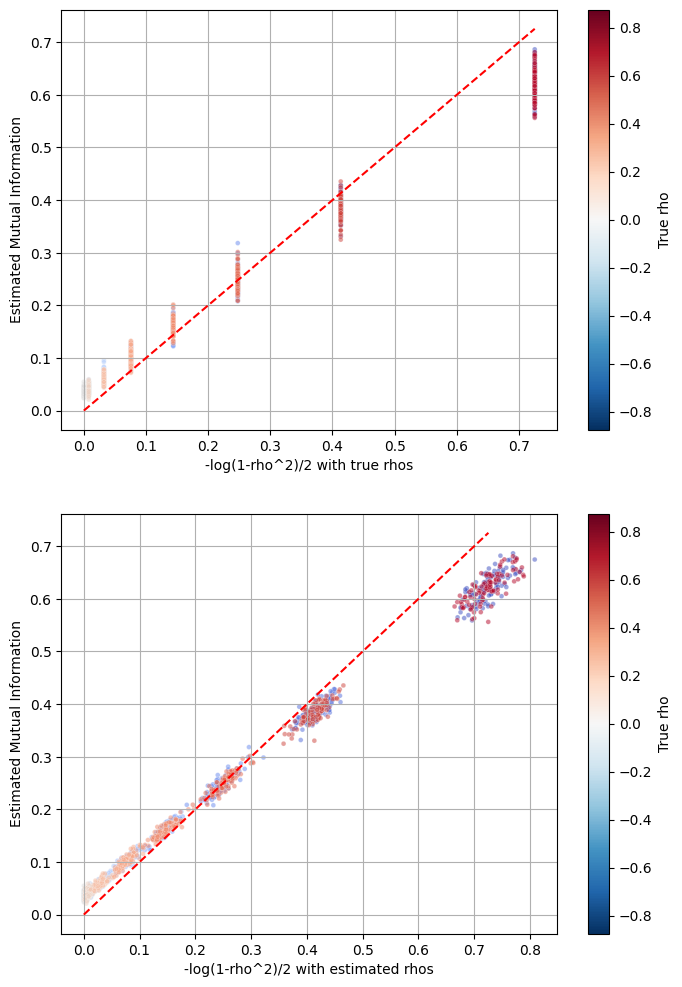

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(8, 12))

xs_max = np.max(log_df["calculated_mi_rho_theoretical"])
xx = np.linspace(0, xs_max, 100)

axs[0].plot(xx, xx, color="red", linestyle="--")
sns.scatterplot(data=log_df, 
                x="calculated_mi_rho_theoretical", 
                y="estimated_mi", 
                hue="rho", ax=axs[0], 
                palette="coolwarm", 
                s=12,
                alpha=0.5
)

axs[0].grid(True)

norm = plt.Normalize(log_df["rho"].min(), log_df["rho"].max())
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
sm.set_array([])

axs[0].get_legend().remove()
plt.colorbar(sm, ax=axs[0], label="True rho")
axs[0].set_xlabel("-log(1-rho^2)/2 with true rhos")
axs[0].set_ylabel("Estimated Mutual Information")


axs[1].plot(xx, xx, color="red", linestyle="--")
sns.scatterplot(
    data=log_df,
    x="calculated_mi_rho_estimated",
    y="estimated_mi",
    hue="rho",
    ax=axs[1],
    palette="coolwarm",
    s=12,
    alpha=0.5,
)
axs[1].grid(True)

norm = plt.Normalize(log_df["rho"].min(), log_df["rho"].max())
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
sm.set_array([])

axs[1].get_legend().remove()
plt.colorbar(sm, ax=axs[1], label="True rho")
axs[1].set_xlabel("-log(1-rho^2)/2 with estimated rhos")
axs[1].set_ylabel("Estimated Mutual Information")

plt.show()

The relationships between the x and y for both plots are close to the identity relationship, 
but there are visible differences and $y = x$ is not the best fit for these results. However, this can be the result of the way of calculating the mutual information.


### b)

#### bp 1)

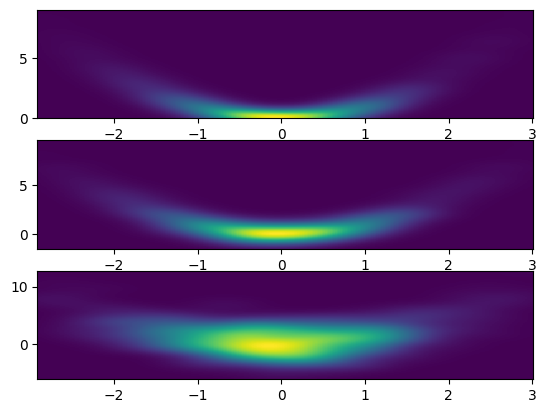

In [20]:
fig, axs = plt.subplots(3)

n = 1000
x = np.random.normal(0, 1, n)

data_2d = np.array([x, x**2 + np.random.normal(0, 0, n)]).T
xi_0, yi_0, zi_0 = plot_xyz(data_2d)
data_2d = np.array([x, x**2 + np.random.normal(0, 0.5, n)]).T
xi_1, yi_1, zi_1 = plot_xyz(data_2d)
data_2d = np.array([x, x**2 + np.random.normal(0, 2, n)]).T
xi_2, yi_2, zi_2 = plot_xyz(data_2d)
 
# Make the plot
axs[0].pcolormesh(xi_0, yi_0, zi_0.reshape(xi_0.shape), shading='auto')
axs[1].pcolormesh(xi_1, yi_1, zi_1.reshape(xi_1.shape), shading='auto')
axs[2].pcolormesh(xi_2, yi_2, zi_2.reshape(xi_2.shape), shading='auto')
plt.show()

#### bp 2) and 3)

In [21]:
np.random.seed = 0
x = np.random.normal(0, 1, n)
def generate_data_2(x, sigma, n): 
    data_2d = np.array([x, x**2 + np.random.normal(0, sigma, n)]).T
    return data_2d

In [22]:
data = generate_data_2(x, 0, 1000)
calculate_stats(data)

(0.07391903213753473, 0.46192000146716883, 0.4619200014671684)

In [23]:
data = generate_data_2(x, 0.5, 1000)
calculate_stats(data)

(0.0684325707824894, 0.46682973566297387, 0.46682973566297425)

In [24]:
data = generate_data_2(x, 1, 1000)
calculate_stats(data)

(0.03871006574154816, 0.30143210559955236, 0.3014321055995523)

In [25]:
sigmas = np.linspace(0, 1, 21)
sigmas

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [26]:
N = 100

In [27]:
pearson_rhos_2 = np.zeros((len(sigmas), N))
custom_mis_2 = np.zeros((len(sigmas), N))
sklearn_mis_2 = np.zeros((len(sigmas), N))

for j in range(N):
    x = np.random.normal(0, 1, n)
    for i, sigma in enumerate(sigmas):
        data = generate_data_2(x, sigma, 1000)
        pearson_rhos_2[i, j], custom_mis_2[i, j], sklearn_mis_2[i, j] = calculate_stats(data)

In [28]:
pearson_rhos_df_2 = pd.DataFrame(pearson_rhos_2, index=sigmas)
mis_df_2 = pd.DataFrame(custom_mis_2, index=sigmas)

pearson_rhos_df_2 = pearson_rhos_df_2.stack().reset_index()
pearson_rhos_df_2.columns = ['sigma', 'id', 'value']
pearson_rhos_df_2["measure"] = "Pearson corr. coef."

mis_df_2 = mis_df_2.stack().reset_index()
mis_df_2.columns = ['sigma', 'id', 'value']
mis_df_2["measure"] = "Mutual Information"

res_df_2 = pd.concat([pearson_rhos_df_2, mis_df_2])

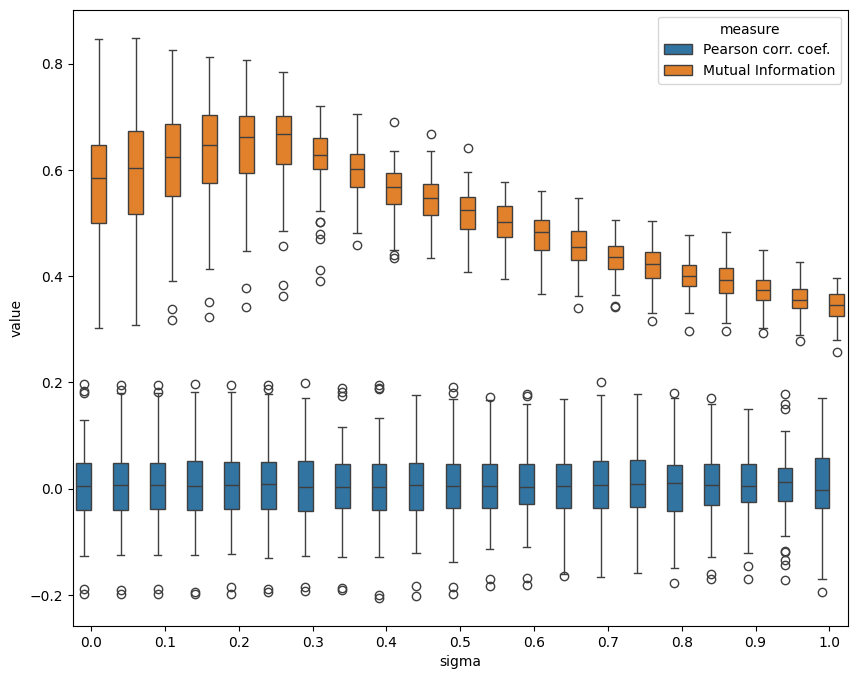

In [29]:
plt.figure(figsize=(10, 8))
sns.boxplot(data=res_df_2, x='sigma', y='value', hue='measure')
plt.xticks(np.arange(0, 21, 2), np.round(sigmas[::2], 2))
plt.show()

## Task 2

### a)

In [30]:
def asymptotic_independence_test(x, y, stats = "mi", bins=10):
    n = len(x)
    x = discretize(x, bins)
    y = discretize(y, bins)
    
    if stats == "mi":
        mi = custom_mutual_info_discrete(x, y, bins)
        stat_value = 2 * n * mi
    elif stats == "chi2":
        contingency = np.histogram2d(x, y, bins=bins)[0]
        stat_value = chi2_contingency(contingency)[0]
    
    p_value = chi2.sf(stat_value, (bins - 1) ** 2)

    return stat_value, p_value

### b)

In [31]:
def permutation_independence_test(x, y, B=100, bins=10):
    n = len(x)
    x = discretize(x, bins)
    y = discretize(y, bins)
    
    mi_org = custom_mutual_info_discrete(x, y, bins)
    
    mis = np.zeros(B)
    for i in range(B):
        mis[i] = custom_mutual_info_discrete(np.random.permutation(x), y, bins)
    
    p_value = (1 + np.sum(mi_org <= mis)) / (1 + B) 
    
    return 2 * n * mi_org, p_value

### c)

**Independent r.v.**

A hint: two discretized independent normal random variables (or any two independent discrete r.v.)

In [32]:
# independent r.v. - we expect that our tests don't reject the null hypothesis

In [33]:
x, y = generate_data(0, 1000).T

In [34]:
asymptotic_independence_test(x, y, stats="mi")

(65.42973180048227, 0.8959065370221132)

In [35]:
asymptotic_independence_test(x, y, stats="chi2")

(66.9999494689849, 0.8680859185602311)

In [36]:
permutation_independence_test(x, y)

(65.42973180048227, 0.7524752475247525)

As expected, we see that all tests do not reject the null hypothesis that the two random variables are independent (assuming a significance level of 0.05).

**Dependent r.v.**

A hint: two discretized dependent normal random variables (or two categorical wuch that we enforce $X=Y$ for a subset of observations)

In [37]:
# independent r.v. - ideally we will reject the null hypothesis

In [38]:
x, y = generate_data(0.5, 1000).T

In [39]:
asymptotic_independence_test(x, y, stats="mi")

(300.45706962652605, 5.756628258310925e-27)

In [40]:
asymptotic_independence_test(x, y, stats="chi2")

(1331.3042640351557, 2.2206880191656178e-225)

In [41]:
permutation_independence_test(x, y)

(300.45706962652605, 0.009900990099009901)

All tests reject the null hypothesis that the two random variables are independent (assuming a significance level of 0.05).